# 0. Import libraries

In [1]:
# 0. Import

import os, sys, json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [2]:
import celloracle as co
co.__version__

'0.6.3'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 0.1. Check installation

Celloracle uses some R libraries in network analysis. 
Please make sure that all dependent R libraries are installed on your computer.
You can test the installation with the following command.

In [4]:
co.network_analysis.test_R_libraries_installation()

R path: /home/lorena/anaconda3/envs/celloracle_env/bin/R
checking R library installation: igraph -> OK
checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK


## 0.2. Make a folder to save graph

In [5]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

 # 1. Load data
## 1.1. Load processed gene expression data (anndata)
Please refer to the previous notebook in the tutorial for an example of how to process scRNA-seq data.

In [6]:
# Load data. !!Replace the data path below when you use another data.
adata = sc.read_h5ad("./inputs/pancreas_data.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# 2. Initiate Oracle object

Celloracle has a custom called Oracle. We can use Oracle for the data preprocessing and GRN inference steps.
The Oracle object stores all of necessary information and does the calculations with its internal functions.
We instantiate an Oracle object, then input the gene expression data (anndata) and a TFinfo into the Oracle object.

In [8]:
# Instantiate Oracle object
oracle = co.Oracle()

Ne## 2.1. load gene expression data into oracle object.

When you load a scRNA-seq data, please enter the name of clustering data and dimensional reduction data.
The clustering data should be to be stored in the attribute of "obs" in the anndata.
Dimensional reduction data suppose to be stored in the attribute of "obsm" in the anndata.
You can check these data by the following command.

If you are not familiar with anndata, please look at the documentation of annata (https://anndata.readthedocs.io/en/stable/) or Scanpy (https://scanpy.readthedocs.io/en/stable/).

For the celloracle analysis, the anndata shoud include (1) gene expression count, (2) clustering information, (3) trajectory (dimensional reduction embeddings) data. Please refer to another notebook for more information on anndata preprocessing.



In [9]:
# show data name in anndata
print("metadata columns :", list(adata.obs.columns))
print("dimensional reduction: ", list(adata.obsm.keys()))

metadata columns : ['clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts']
dimensional reduction:  ['X_pca', 'X_umap']


In [10]:
# In this notebook, we use raw mRNA count as an input of Oracle object.
#adata.X = adata.raw.X.copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="clusters",
                                   embedding_name="X_umap", 
                                   transform=None) #already done using scVelo

## 2.2. Load TFinfo into oracle object

In [11]:
with open('TF_targets_pancreas.json', 'r') as fp:
    TF_info = json.load(fp)

In [12]:
# Add TF information 
oracle.addTFinfo_dictionary(TF_info)

# 3. Knn imputation
Celloracle uses almost the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we need PCA and PC selection first.

## 3.1. PCA

24


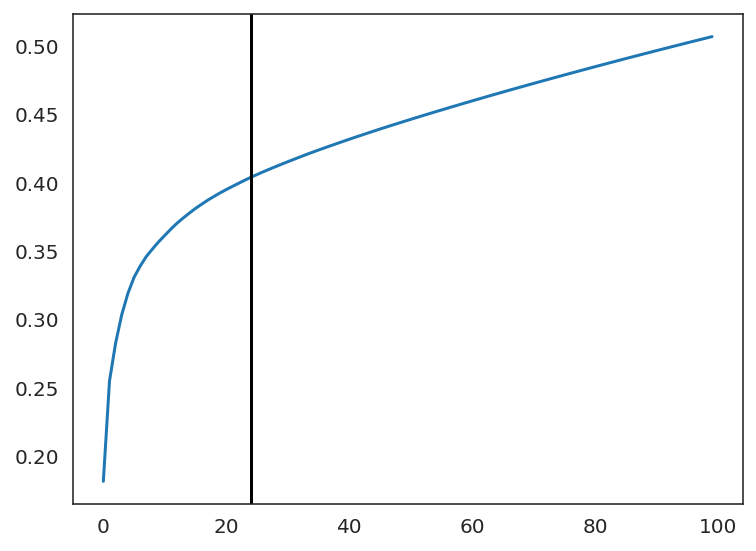

In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
oracle.pcs[:, :24].shape

(3696, 24)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [15]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :3696


In [16]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :92


In [17]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=12)

# 4. Save and Load.

Celloracle has some custom-classes: Links, Oracle and TFinfo.
You can save such an object using "to_hdf5".

Please use "load_hdf5" function to load the file.


In [18]:
# Save oracle object.
oracle.to_hdf5("Pancreas_data.celloracle.oracle")

In [19]:
# Load file.
#oracle = co.load_hdf5("Pancreas_data.celloracle.oracle")

# 5. GRN calculation
The next step is constructing a cluster-specific GRN for all clusters.

You can calculate  GRNs with the "get_links" function, and the function returns GRNs as a Links object.
The Links object stores inferred GRNs and the corresponding metadata. You can do network analysis with the Links object.

The GRN will be calculated for each cluster/sub-group.

The GRNs can be calculated at any arbitrary unit as long as the clustering information is stored in anndata.

In [20]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [21]:
# check data
sc.tl.draw_graph(adata)

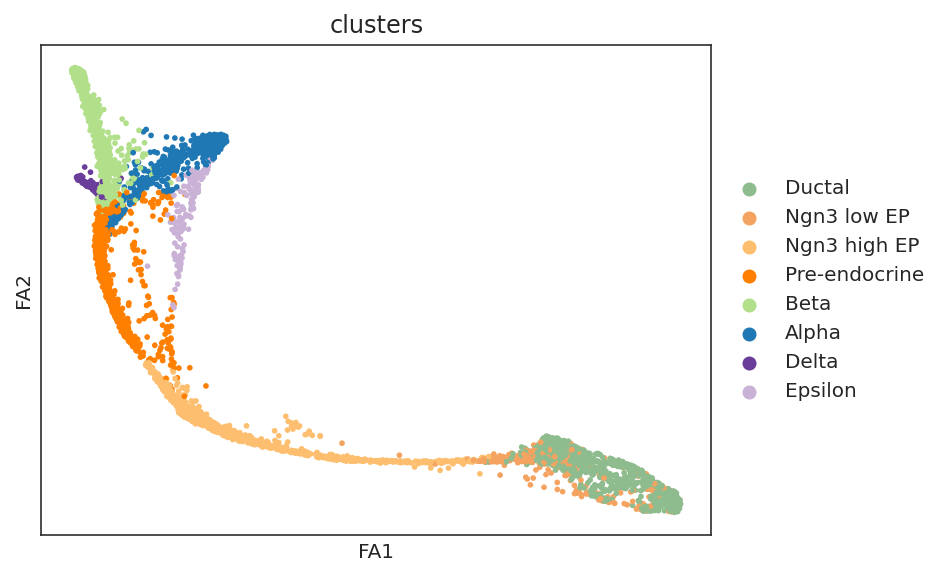

In [22]:
sc.pl.draw_graph(adata, color = "clusters")

## 5.1. Get GRNs

In [25]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take long time.
links = oracle.get_links(cluster_name_for_GRN_unit="clusters", alpha=10,
                         verbose_level=10, test_mode=False)

  0%|          | 0/8 [00:00<?, ?it/s]

inferring GRN for Alpha...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Beta...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Delta...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Ductal...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Epsilon...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Ngn3 high EP...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Ngn3 low EP...


  0%|          | 0/1857 [00:00<?, ?it/s]

inferring GRN for Pre-endocrine...


  0%|          | 0/1857 [00:00<?, ?it/s]

CPU times: user 15min 8s, sys: 42 s, total: 15min 50s
Wall time: 16min 15s


## 5.2. (Optional) Export GRNs

Although celloracle has many functions for network analysis, you can analyze GRNs by hand if you choose.
The raw GRN data is stored in the attribute of "links_dict".

For example, you can get the GRN for the "Ngn3 high EP" cluster with the following commands.

In [27]:
links.links_dict.keys()

dict_keys(['Alpha', 'Beta', 'Delta', 'Ductal', 'Epsilon', 'Ngn3 high EP', 'Ngn3 low EP', 'Pre-endocrine'])

In [28]:
links.links_dict['Ngn3 high EP']

,source,target,coef_mean,coef_abs,p,-logp
0,Nfib,0610010F05Rik,-0.002893,0.002893,4.405870e-03,2.355968
1,Rfx2,0610010F05Rik,0.001816,0.001816,3.996444e-02,1.398326
2,Pax6,0610010F05Rik,0.003500,0.003500,5.624745e-04,3.249897
3,Hnf4a,0610010F05Rik,-0.007582,0.007582,1.519189e-09,8.818388
4,Zfhx2,0610010F05Rik,-0.000326,0.000326,6.624696e-01,0.178834
...,...,...,...,...,...,...
138648,Xbp1,Zwint,-0.028998,0.028998,5.552358e-09,8.255523
138649,Atf6,Zwint,0.000507,0.000507,8.026560e-01,0.095471
138650,Pax4,Zwint,0.037880,0.037880,9.931640e-11,10.002979
138651,Fosb,Zwint,-0.000376,0.000376,8.895902e-01,0.050810


In [56]:
links.links_dict['Beta']

,source,target,coef_mean,coef_abs,p,-logp
0,Nfib,0610010F05Rik,0.001912,0.001912,4.407733e-03,2.355785
1,Rfx2,0610010F05Rik,0.006719,0.006719,1.787159e-09,8.747837
2,Pax6,0610010F05Rik,0.016192,0.016192,1.185630e-11,10.926051
3,Hnf4a,0610010F05Rik,-0.008023,0.008023,2.170588e-12,11.663423
4,Zfhx2,0610010F05Rik,-0.008121,0.008121,3.017352e-08,7.520374
...,...,...,...,...,...,...
138648,Xbp1,Zwint,-0.050203,0.050203,1.959907e-12,11.707764
138649,Atf6,Zwint,0.000140,0.000140,9.438421e-01,0.025101
138650,Pax4,Zwint,-0.017014,0.017014,4.785871e-03,2.320039
138651,Fosb,Zwint,0.010080,0.010080,8.837434e-04,3.053674


You can export the file as follows.

In [29]:
# Set cluster name
#cluster = "Ngn3 high EP"

# Save as csv
#links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}.csv")

## 5.3. (Optional) Change order

The links object has a color information in an attribute, "palette".
This information is used for the visualization

The sample will be visualized in that order. 
Here we can change the order.

In [30]:
# Show the contents of pallete
links.palette

,palette
Ductal,#8FBC8F
Ngn3 low EP,#F4A460
Ngn3 high EP,#FDBF6F
Pre-endocrine,#FF7F00
Beta,#B2DF8A
Alpha,#1F78B4
Delta,#6A3D9A
Epsilon,#CAB2D6


In [31]:
# Change the order of pallete
#order = ['MEP_0', 'Mk_0','Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5',
#         'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9','GMP_0', 'GMP_1',
#         'GMPl_0', 'Mo_0', 'Mo_1', 'Gran_0', 'Gran_1', 'Gran_2']
#links.palette = links.palette.loc[order]
#links.palette

# 6. Network preprocessing

## 6.1. Filter network edges 
Celloracle utilizes bagging ridge or Bayesian ridge regression to infer gene regulatory networks. 
These methods provide a network edge strength as a distribution rather than a point value. 
We can use the distribution to know the certainness of the connection.

We filter the network edges as follows.

 (1) Remove uncertain network edges based on the p-value.
 
 (2) Remove weak network edge. In this tutorial, we pick up the top 2000 edges in terms of network strength.


The raw network data is stored as an attribute, "links_dict," while filtered network data is stored in "filtered_links." 
Thus the filtering function keeps raw network information rather than overwriting the data. You can come back to the filtering process to filter the data with different parameters if you want.

In [32]:
links.filter_links(p=0.001, weight="coef_abs", thread_number=2000)

I didn't know if we were looking at transcription factors or genes (source or target), so I picked one at random for Ngn3 high EP cluster and then looked at its centrality degree.
Turns out we are looking only at transcription factors.

In [138]:
links.filtered_links["Ngn3 high EP"][links.filtered_links["Ngn3 high EP"]["source"] == "Rora"]

,source,target,coef_mean,coef_abs,p,-logp
135271,Rora,Xist,-0.296642,0.296642,5.246216e-12,11.280154
80970,Rora,Nit2,0.144832,0.144832,2.493664e-11,10.603162
15265,Rora,Casp6,-0.108628,0.108628,1.662234e-20,19.779308
124793,Rora,Tmsb4x,-0.065627,0.065627,1.770167e-10,9.751986
120125,Rora,Syt7,-0.051160,0.051160,8.181250e-07,6.087180
57659,Rora,Idh2,0.049859,0.049859,5.756964e-06,5.239807
126477,Rora,Tpst2,-0.042964,0.042964,8.192325e-11,10.086593
79899,Rora,Neurog3,-0.040532,0.040532,1.869310e-10,9.728319
19574,Rora,Cdkn1c,-0.039558,0.039558,1.234915e-10,9.908363
70265,Rora,Malat1,0.039130,0.039130,3.051526e-10,9.515483


In [139]:
links.filtered_links["Ngn3 high EP"][links.filtered_links["Ngn3 high EP"]["target"] == "Rora"]

,source,target,coef_mean,coef_abs,p,-logp


Here, I wanted to analyze the network as it is written in the code and also visualize it (if possible).

In [140]:
import networkx as nx
import collections
import matplotlib.pyplot as plt

In [141]:
G=nx.DiGraph()
G_ = nx.from_pandas_edgelist(links.filtered_links["Ngn3 high EP"], edge_attr=True)
G.add_edges_from(G_.edges())

In [142]:
G.degree

DiDegreeView({'Zfhx2': 31, 'Dbn1': 11, 'Clu': 27, 'Igfbpl1': 26, '2810417H13Rik': 10, 'Spp1': 39, 'Akr1c19': 12, 'Serpina1c': 22, 'Mgst1': 17, 'Arl6ip1': 8, 'Hagh': 5, 'Cks2': 8, 'Mpzl1': 11, 'Cks1b': 10, 'Tuba1b': 8, 'Gfra3': 14, 'Ambp': 16, 'Cdkn1a': 29, 'Xist': 57, 'Hmmr': 2, 'Spc25': 6, 'Stmn1': 2, 'H19': 13, 'Rps4x': 2, 'Pebp1': 10, 'Hnrnpa1': 2, 'Peg3': 26, 'Hmgb2': 41, 'Gadd45a': 26, 'Gars': 9, 'Fev': 35, 'Calr': 4, 'Prdm16': 13, 'Meis3': 15, 'Vdr': 20, 'Nr1h4': 4, 'Etv5': 7, 'Pknox1': 6, 'Meis2': 17, 'Ezh2': 59, 'Zfp672': 5, 'Prkar1b': 3, 'Cck': 46, 'Tmsb4x': 22, 'Acot1': 13, 'Necab2': 3, 'Cpe': 6, 'Pgrmc1': 5, 'Rps2': 4, 'Krt8': 7, 'Rnase4': 3, 'Hes1': 38, 'Dbi': 12, 'Mt2': 12, 'Mt1': 11, 'Qdpr': 10, 'Syt13': 12, 'Neurog3': 41, 'Lrrc42': 8, 'Tpst2': 11, 'Ttc28': 5, 'Eno1': 8, 'Pax4': 109, 'Bicc1': 6, 'Malat1': 17, 'Tecpr1': 3, 'Clps': 4, 'Trappc2l': 2, 'Svip': 4, 'Wfdc2': 6, 'Rgs17': 16, 'S100a10': 4, 'Atp1b1': 8, 'Sparc': 15, 'Abcf3': 1, 'St3gal4': 1, 'Gapdh': 3, 'Dlk1': 9, '

[Text(0, 0, '109'),
 Text(0, 0, '78'),
 Text(0, 0, '72'),
 Text(0, 0, '65'),
 Text(0, 0, '59'),
 Text(0, 0, '57'),
 Text(0, 0, '53'),
 Text(0, 0, '49'),
 Text(0, 0, '46'),
 Text(0, 0, '43'),
 Text(0, 0, '41'),
 Text(0, 0, '40'),
 Text(0, 0, '39'),
 Text(0, 0, '38'),
 Text(0, 0, '36'),
 Text(0, 0, '35'),
 Text(0, 0, '32'),
 Text(0, 0, '31'),
 Text(0, 0, '30'),
 Text(0, 0, '29'),
 Text(0, 0, '28'),
 Text(0, 0, '27'),
 Text(0, 0, '26'),
 Text(0, 0, '25'),
 Text(0, 0, '24'),
 Text(0, 0, '23'),
 Text(0, 0, '22'),
 Text(0, 0, '21'),
 Text(0, 0, '20'),
 Text(0, 0, '18'),
 Text(0, 0, '17'),
 Text(0, 0, '16'),
 Text(0, 0, '15'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

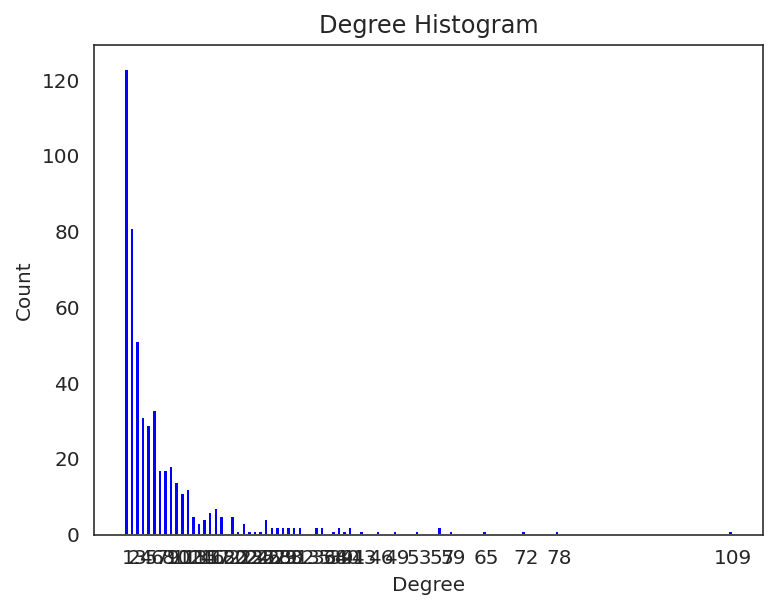

In [143]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

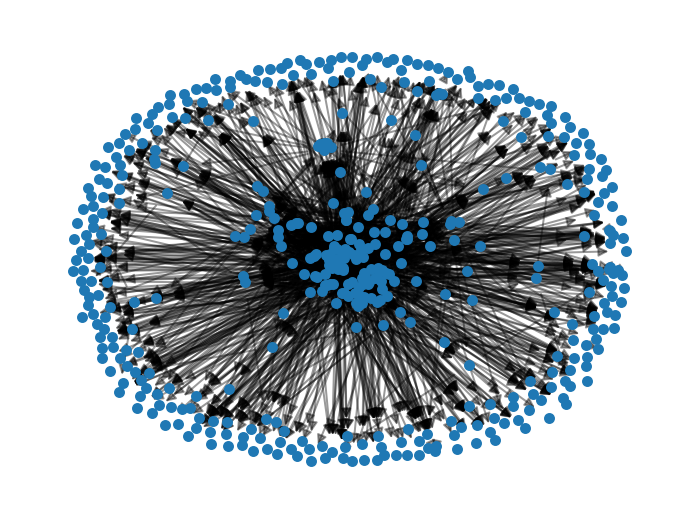

In [130]:
#plot Network
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.
Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [33]:
plt.rcParams["figure.figsize"] = [9, 4.5]

In [144]:
links.plot_degree_distributions?

Signature: links.plot_degree_distributions(plot_model=False, save=None)
Docstring:
Plot the network degree distributions (the number of edge per gene).
The network degree will be visualized in both linear scale and log scale.

Args:
    links (Links): See network_analysis.Links class for detail.
    plot_model (bool): Whether to plot linear approximation line.
    save (str): Folder path to save plots. If the folder does not exist in the path, the function creates the folder.
       Plots will not be saved if [save=None]. Default is None.
File:      ~/anaconda3/envs/celloracle_env/lib/python3.6/site-packages/celloracle/network_analysis/links_object.py
Type:      method


Alpha


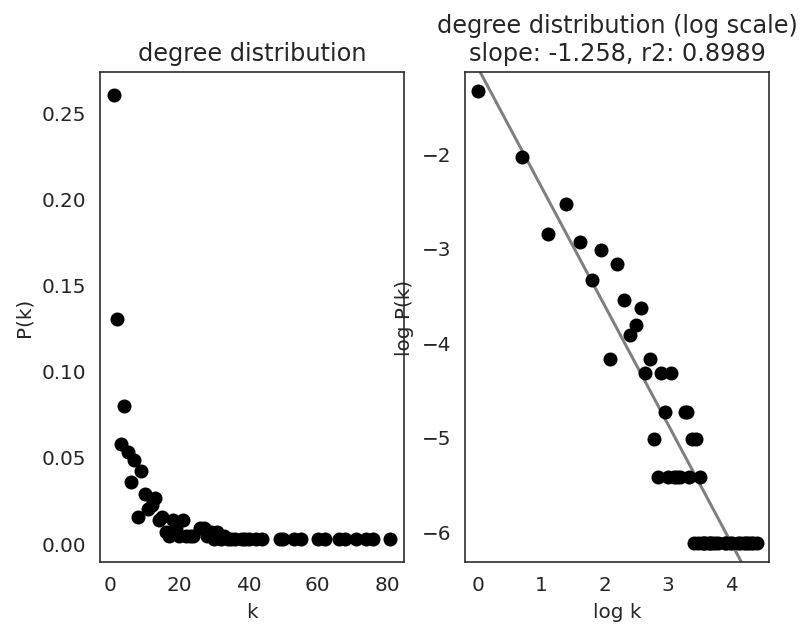

Beta


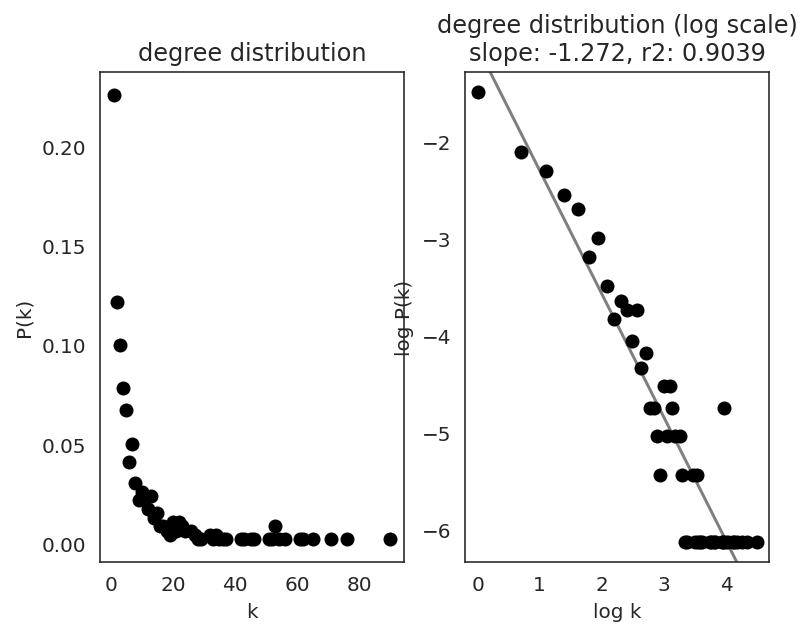

Delta


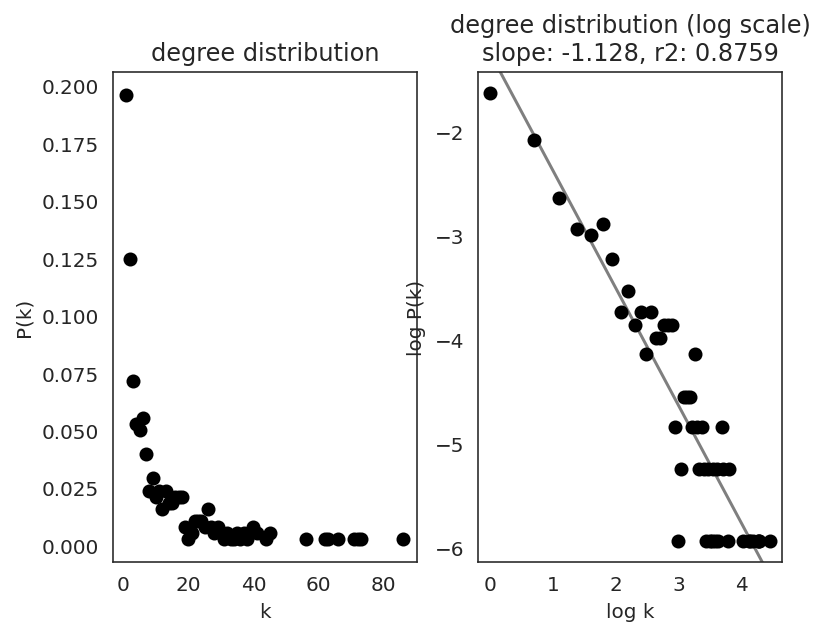

Ductal


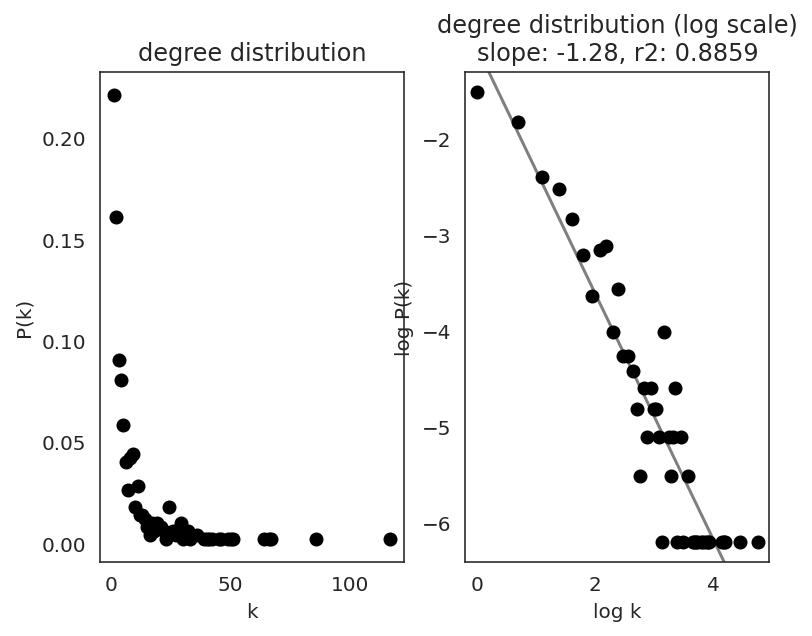

Epsilon


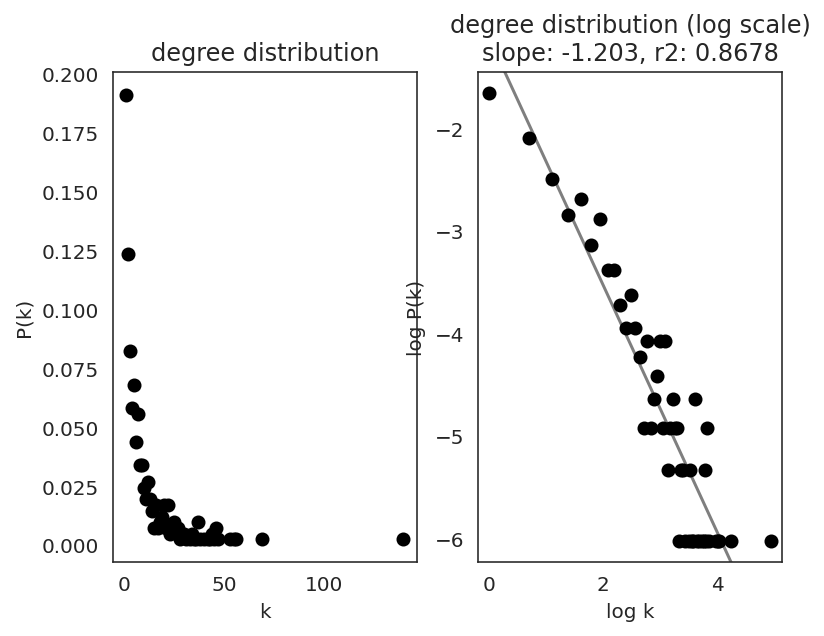

Ngn3 high EP


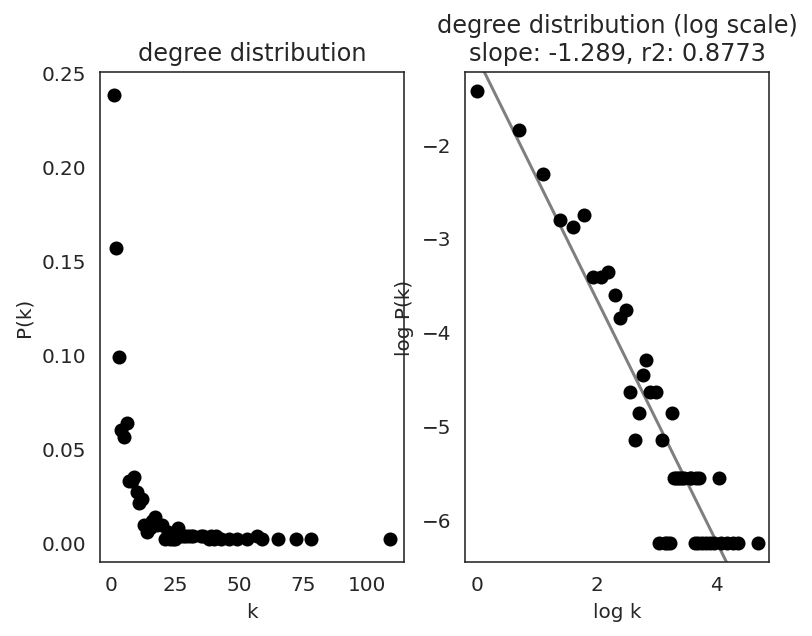

Ngn3 low EP


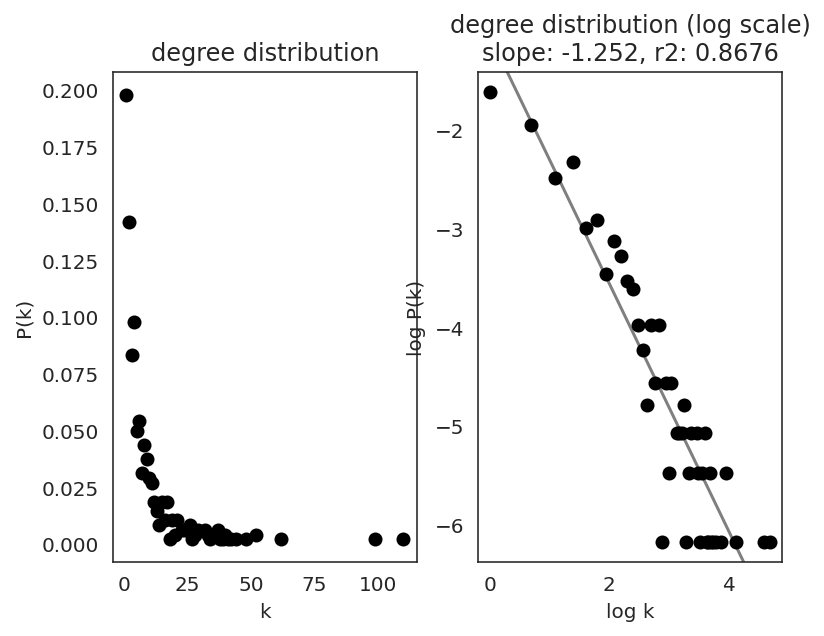

Pre-endocrine


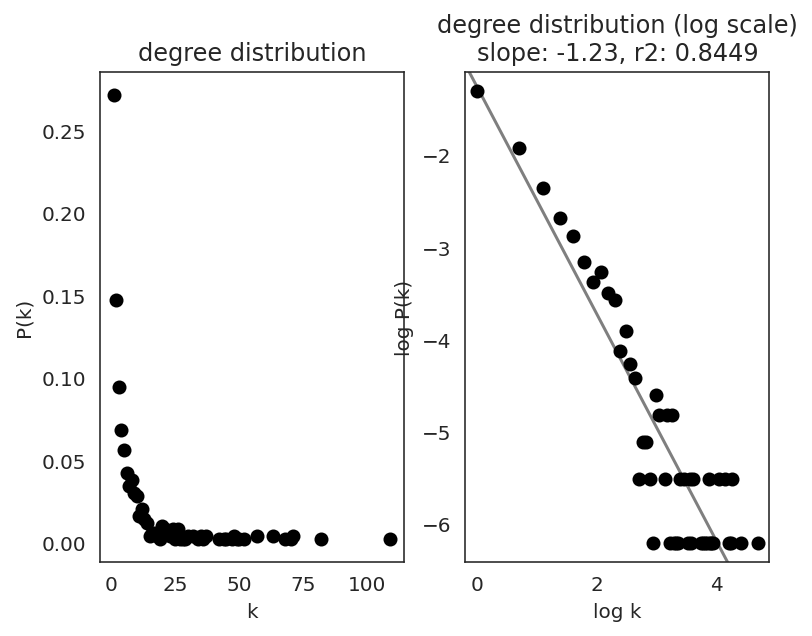

In [75]:
links.plot_degree_distributions(plot_model=True, save=f"{save_folder}/degree_distribution/")

In [35]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 5.3. Calculate network score

Next, we calculate several network score using some R libraries.
Please make sure that R libraries are installed in your PC before running the command below.


In [36]:
# Calculate network scores. It takes several minutes.
links.get_score()

processing... batch 1/1
Alpha: finished.
Beta: finished.
Delta: finished.
Ductal: finished.
Epsilon: finished.
Ngn3 high EP: finished.
Ngn3 low EP: finished.
Pre-endocrine: finished.


The score is stored as a attribute called "merged_score", and the score will also be saved in a folder in your computer.

In [37]:
links.merged_score.head()

,degree_all,degree_in,degree_out,clustering_coefficient,clustering_coefficient_weighted,degree_centrality_all,degree_centrality_in,degree_centrality_out,betweenness_centrality,closeness_centrality,eigenvector_centrality,page_rank,assortative_coefficient,average_path_length,community_random_walk,module,connectivity,participation,role,cluster
Nkx6-1,40,7,33,0.101282,0.132263,0.088496,0.015487,0.073009,2928,0.000015,0.573330,0.002093,-0.281788,3.114764,3,3,2.457922,0.541667,Peripheral,Alpha
Pax6,68,2,66,0.025900,0.030173,0.150442,0.004425,0.146018,2486,0.000015,0.526951,0.001770,-0.281788,3.114764,4,1,6.349190,0.673554,Connector Hub,Alpha
Pax4,55,1,54,0.051852,0.041990,0.121681,0.002212,0.119469,1424,0.000015,0.375205,0.001717,-0.281788,3.114764,3,0,3.573431,0.632066,Connector Hub,Alpha
Meis2,69,5,64,0.043478,0.046754,0.152655,0.011062,0.141593,5554,0.000015,0.557957,0.002254,-0.281788,3.114764,3,3,4.766511,0.606834,Connector Hub,Alpha
Klf13,26,0,26,0.033846,0.033731,0.057522,0.000000,0.057522,0,0.000015,0.207069,0.001694,-0.281788,3.114764,15,3,1.736487,0.523669,Peripheral,Alpha


## 6.4. Save

Save processed GRN. We use this file in the next notebook; "in silico perturbation with GRNs". 

In [38]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [39]:
# You can load files with the following command.
links = co.load_hdf5(file_path="links.celloracle.links")


# 7. Network analysis; Network score for each gene
The Links class has many functions to visualize network score.
See the documentation for the details of the functions.

## 7.1. Network score in each cluster


We have calculated several network scores using different centrality metrics.
We can use the centrality score to identify key regulatory genes because centrality is one of the important indicators of network structure (https://en.wikipedia.org/wiki/Centrality). 

Let's visualize genes with high network centrality.


In [40]:
# Check cluster name
links.cluster

['Alpha',
 'Beta',
 'Delta',
 'Ductal',
 'Epsilon',
 'Ngn3 high EP',
 'Ngn3 low EP',
 'Pre-endocrine']

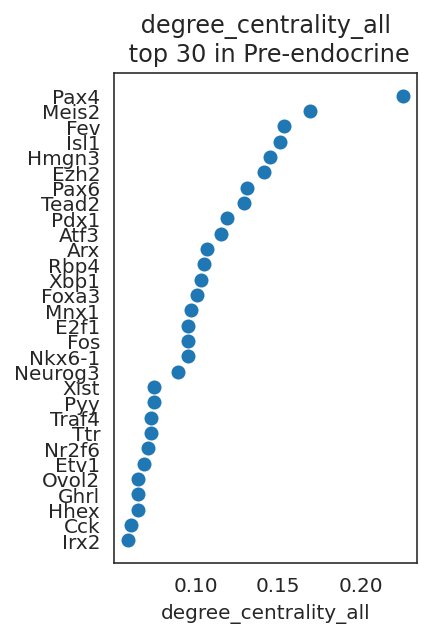

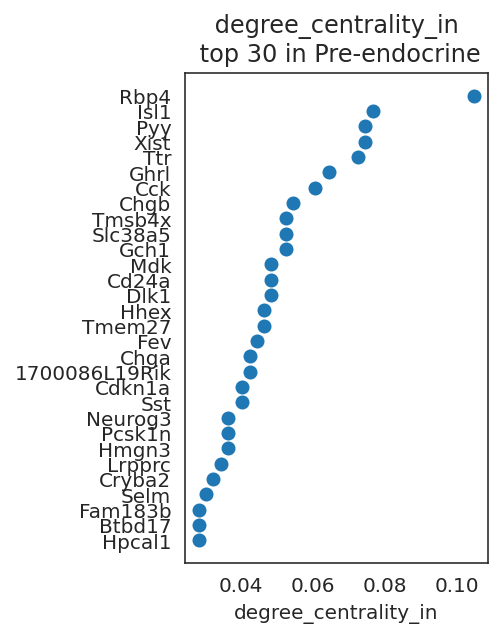

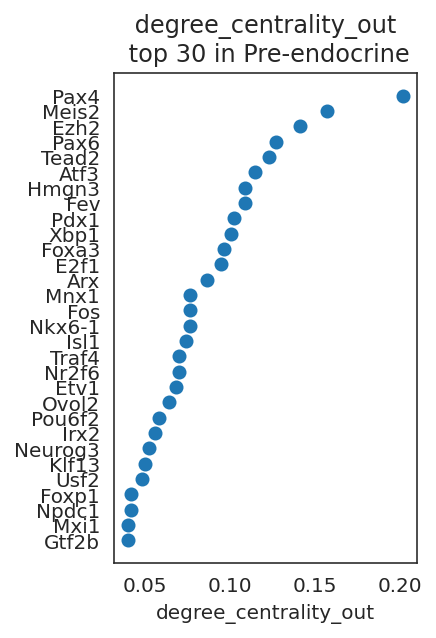

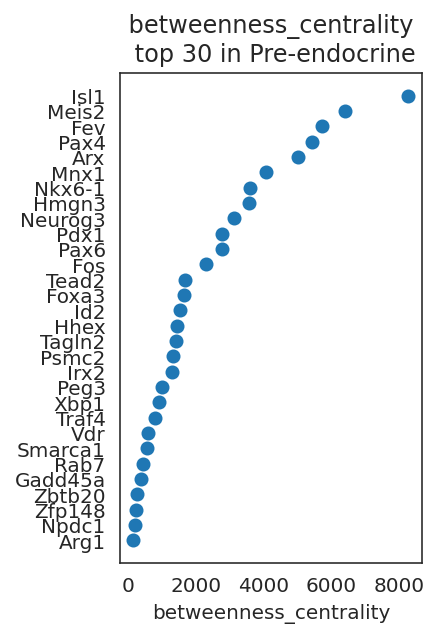

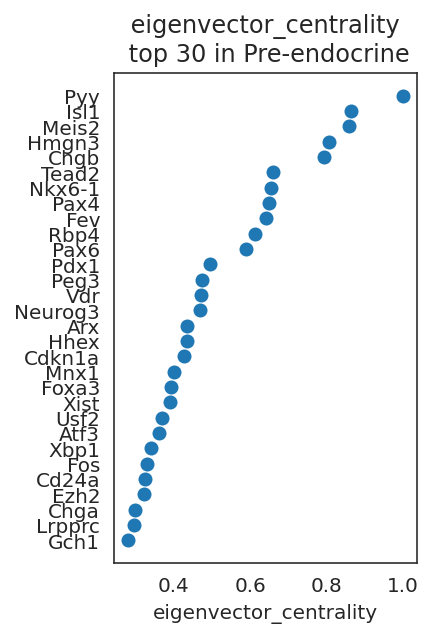

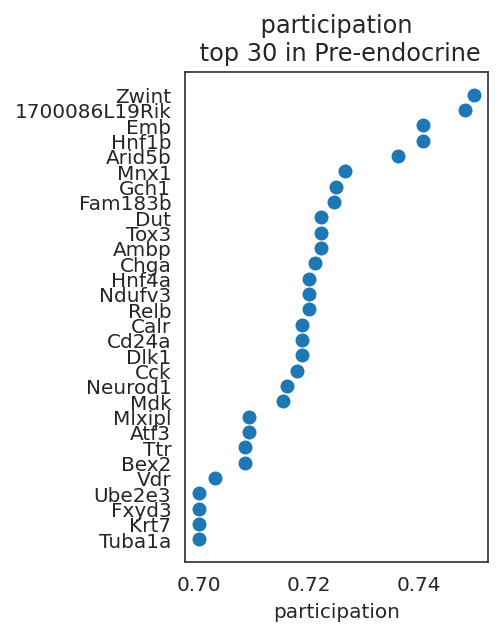

In [112]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="Pre-endocrine", n_gene=30, save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze differences in GRN structure.

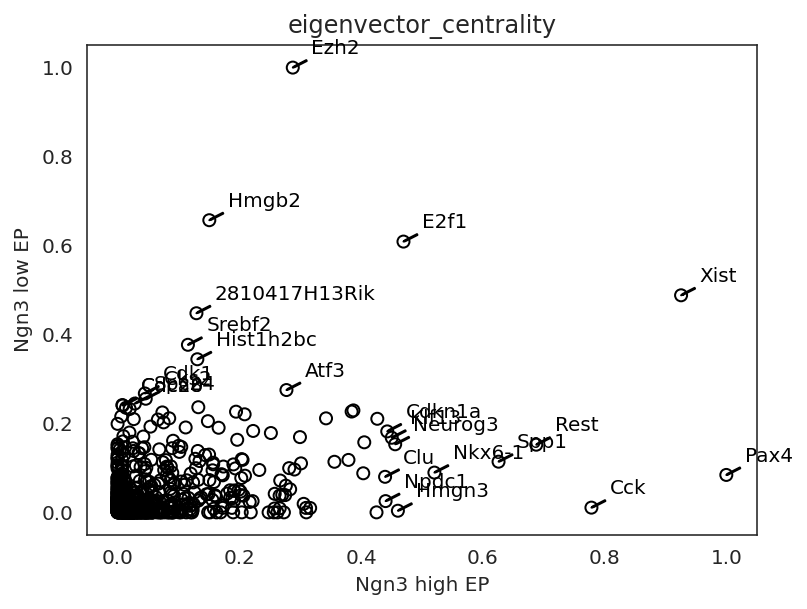

In [113]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Ngn3 high EP", cluster2="Ngn3 low EP", 
                               percentile=98, save=f"{save_folder}/score_comparison")

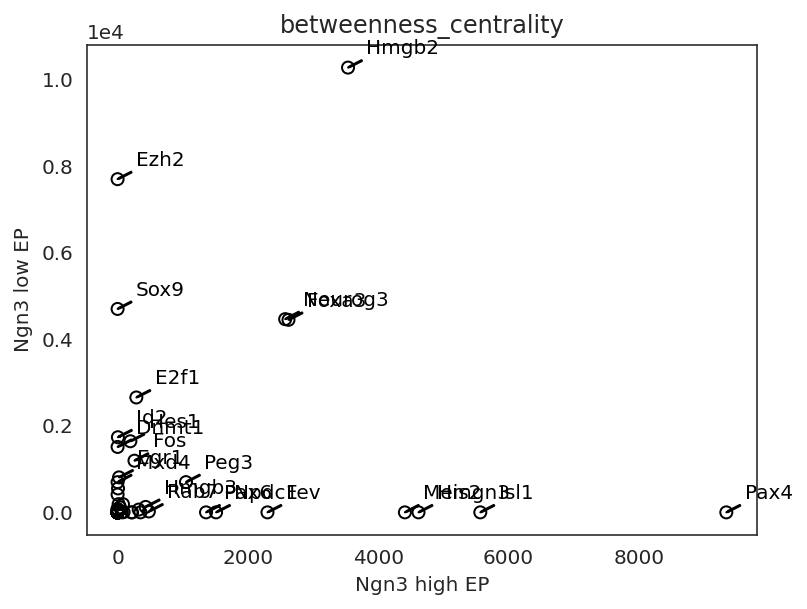

In [114]:

plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="Ngn3 high EP", cluster2="Ngn3 low EP", 
                               percentile=98, save=f"{save_folder}/score_comparison")

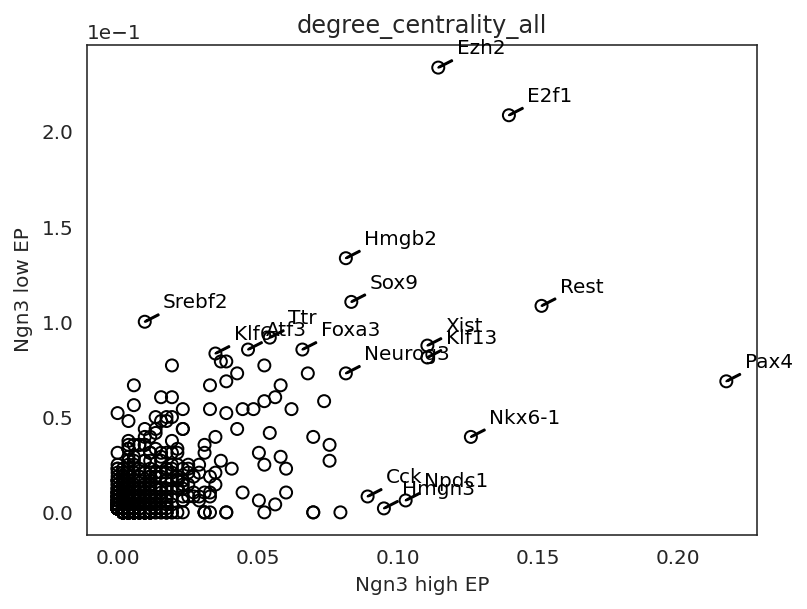

In [115]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="Ngn3 high EP", cluster2="Ngn3 low EP", 
                               percentile=98, save=f"{save_folder}/score_comparison")

## 7.3. Network score dynamics
In the following session, we focus on how a gene's network score changes during the differentiation.

Using Neurog3, we will demonstrate how you can visualize networks scores for a single gene.

Neurog3


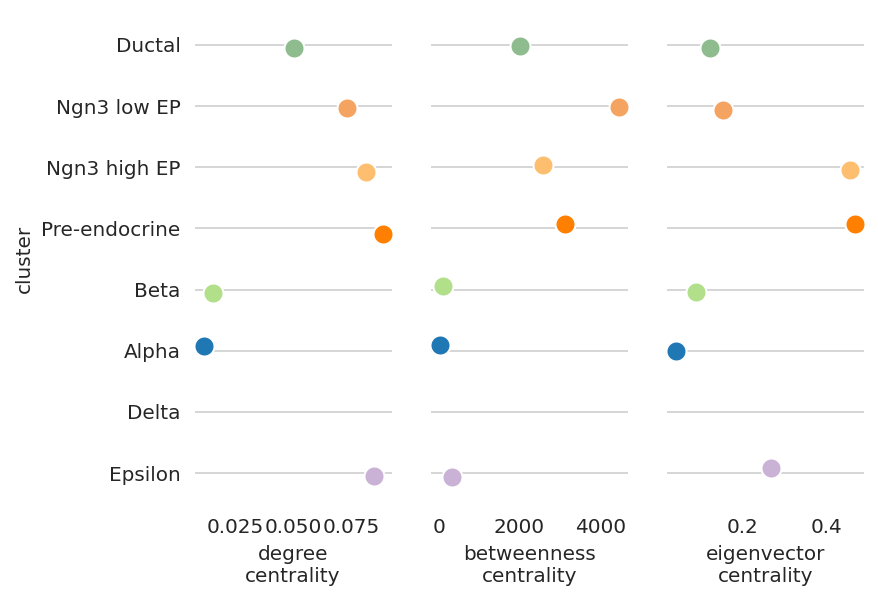

In [45]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="Neurog3", save=f"{save_folder}/network_score_per_gene/")

If a gene have no connections in a cluster, it is impossible to calculate network degree scores.
Thus the scores will not be shown.
For example, Arx have no connection in the ductal and Ngn3 cells, there is no degree scores for Arx in these clusters as follows.

Arx


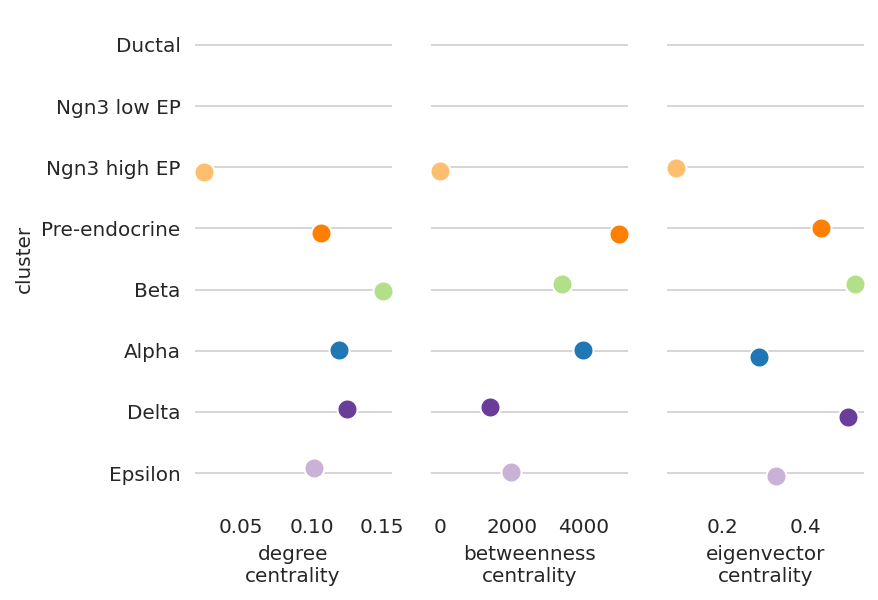

In [46]:
links.plot_score_per_cluster(goi="Arx")

Zeb1


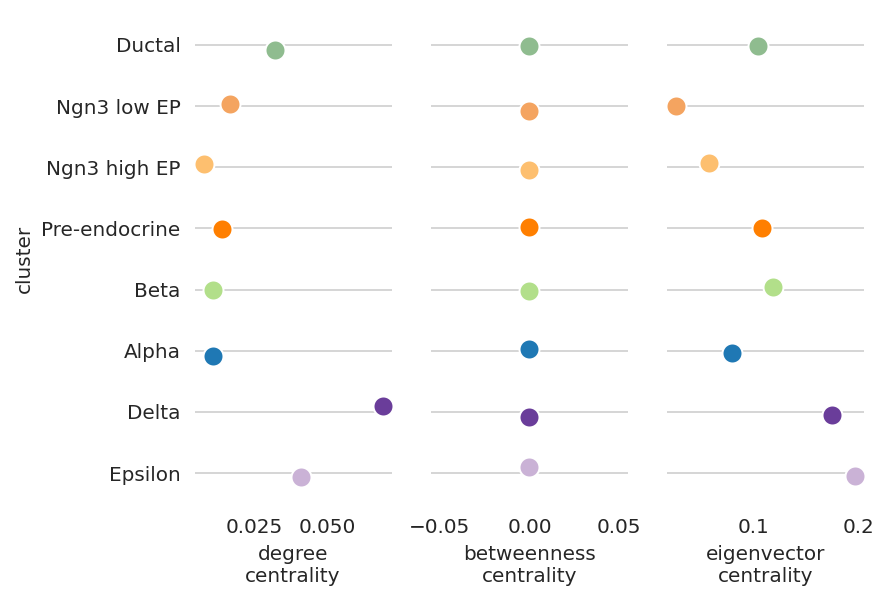

In [116]:
links.plot_score_per_cluster(goi="Zeb1")

You can check filtered network edge as follows.

In [47]:
cluster_name = "Ngn3 high EP"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
29243,Zfhx2,Dbn1,0.368647,0.368647,2.178805e-10,9.661782
29248,Prdm16,Dbn1,-0.317492,0.317492,1.035643e-09,8.984790
29219,Hes1,Dbi,0.298495,0.298495,3.938739e-18,17.404643
135271,Rora,Xist,-0.296642,0.296642,5.246216e-12,11.280154
89894,Nkx6-1,Pebp1,-0.261359,0.261359,1.426498e-16,15.845729


You can confirm that there is no Cebpa connection in Ery_0 cluster.

In [48]:
filtered_links_df[filtered_links_df.source == "Arx"]

,source,target,coef_mean,coef_abs,p,-logp
48489,Arx,Glud1,0.134621,0.134621,1.094379e-09,8.960832
67608,Arx,Litaf,-0.100355,0.100355,2.402132e-09,8.619403
60377,Arx,Isl1,0.072975,0.072975,1.575491e-13,12.802584
4071,Arx,Akr1c19,0.063142,0.063142,5.226976e-08,7.281750
89958,Arx,Peg3,0.058577,0.058577,7.902547e-08,7.102233
19490,Arx,Cdkn1a,0.054022,0.054022,2.840550e-09,8.546598
36280,Arx,Emb,0.053299,0.053299,2.366880e-14,13.625824
2188,Arx,Acat1,-0.044241,0.044241,1.715123e-09,8.765705
114425,Arx,Sms,0.043977,0.043977,3.952473e-11,10.403131
129470,Arx,Ttr,-0.043836,0.043836,1.983942e-09,8.702471


## 7.4. Gene cartography analysis

Gene cartography is a method for gene network analysis.
The method classifies gene into several groups using the network module structure and connections.
It provides us an insight about the role and regulatory mechanism for each gene. 
For more information on gene cartography, please refer to the following paper (https://www.nature.com/articles/nature03288).

The gene cartography will be calculated for the GRN in each cluster.
Thus we can know how the gene cartography change by comparing the the score between clusters.

Alpha


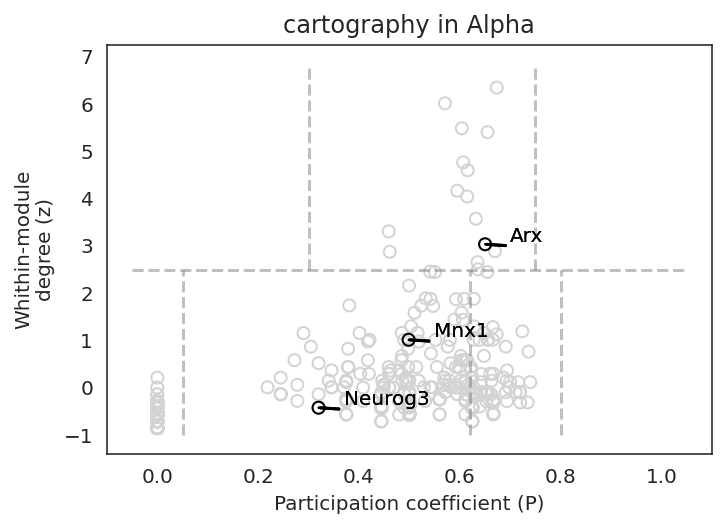

Beta


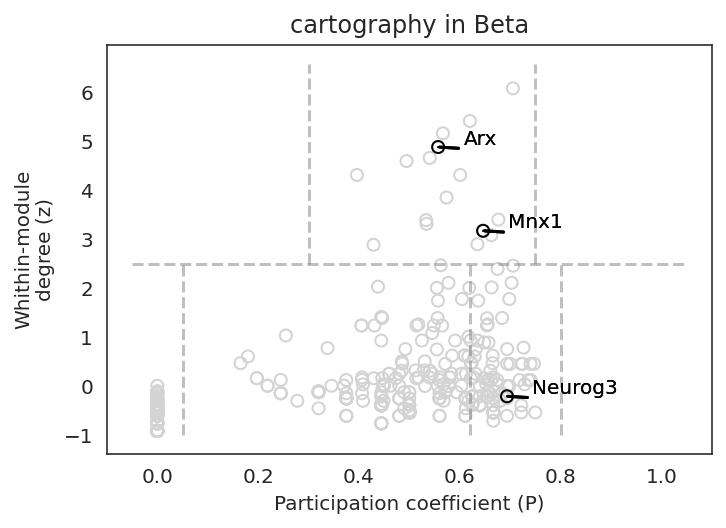

Delta


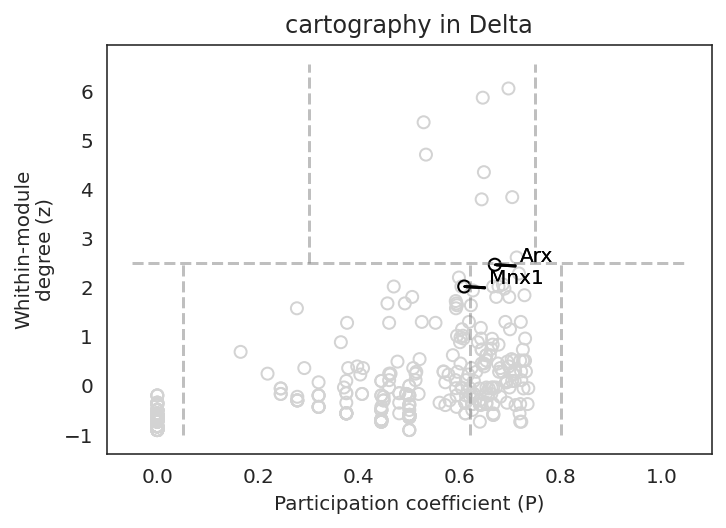

Ductal


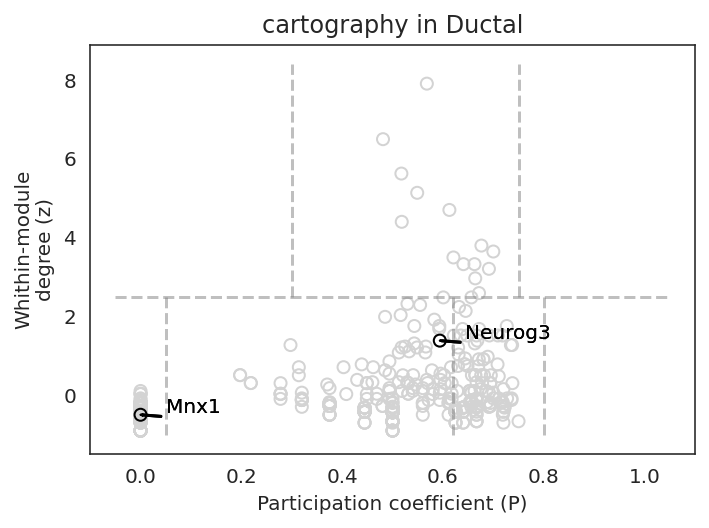

Epsilon


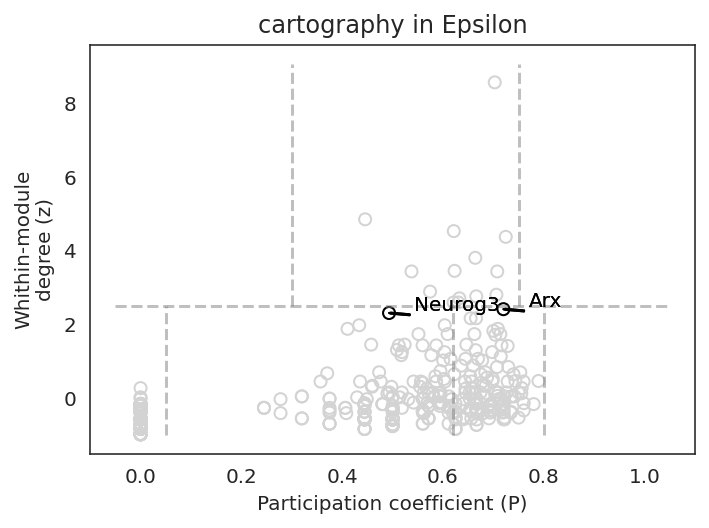

Ngn3 high EP


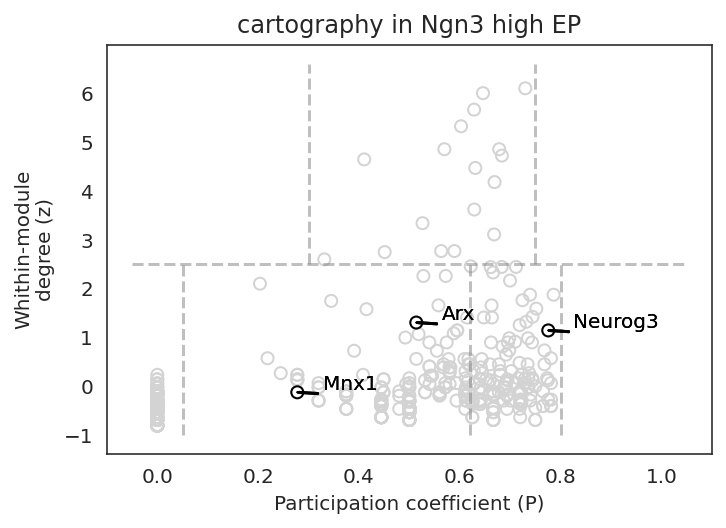

Ngn3 low EP


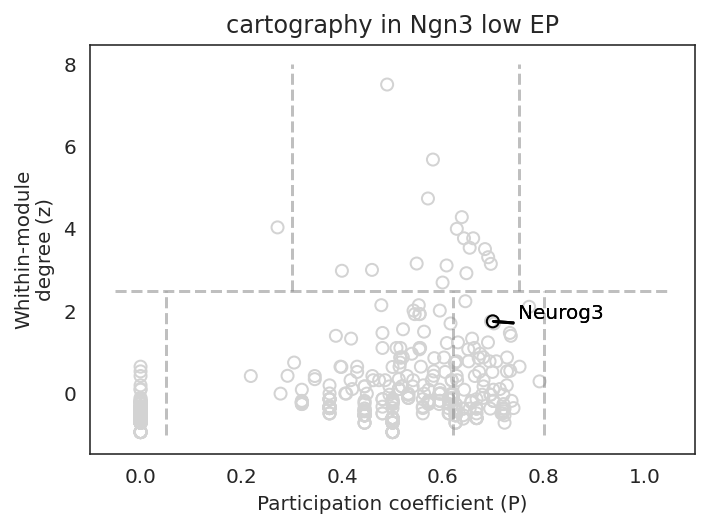

Pre-endocrine


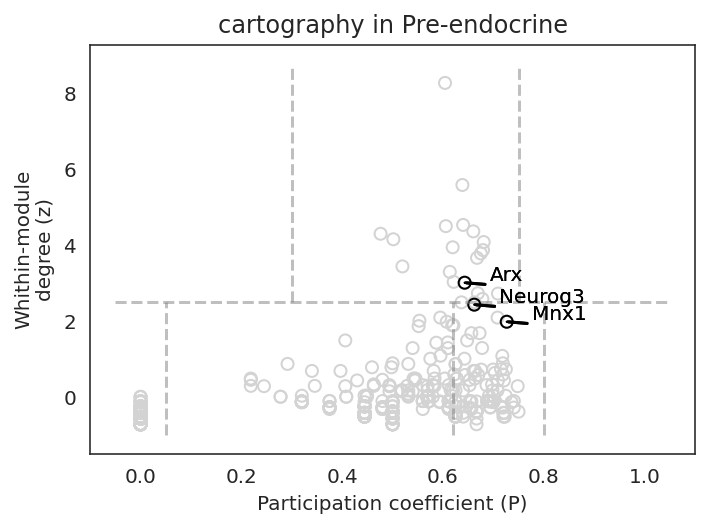

In [49]:
# Plot cartography as a scatter plot
links.plot_cartography_scatter_per_cluster(scatter=True,
                                           kde=False,
                                           gois=["Neurog3", "Arx", "Mnx1"],
                                           auto_gene_annot=False,
                                           args_dot={"n_levels": 105},
                                           args_line={"c":"gray"}, save=f"{save_folder}/cartography")

Neurog3


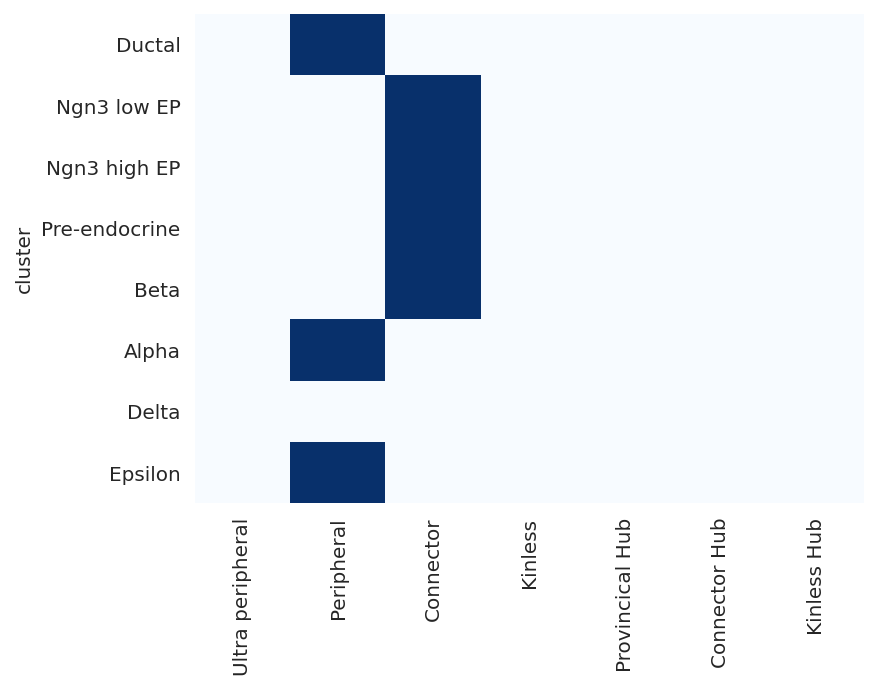

In [50]:
# Plot the summary of cartography analysis
links.plot_cartography_term(goi="Neurog3", save=f"{save_folder}/cartography")

# 8. Network analysis; network score distribution

Next, we visualize the distribution of network score to get insight into the global trend of the GRNs.

## 8.1. Distribution of network degree

degree_centrality_all


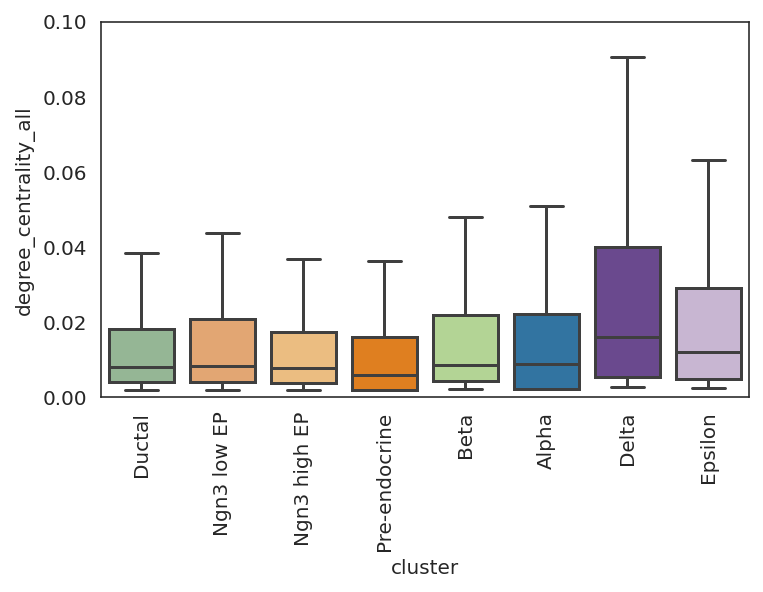

In [51]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.1])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot", save=f"{save_folder}")

eigenvector_centrality


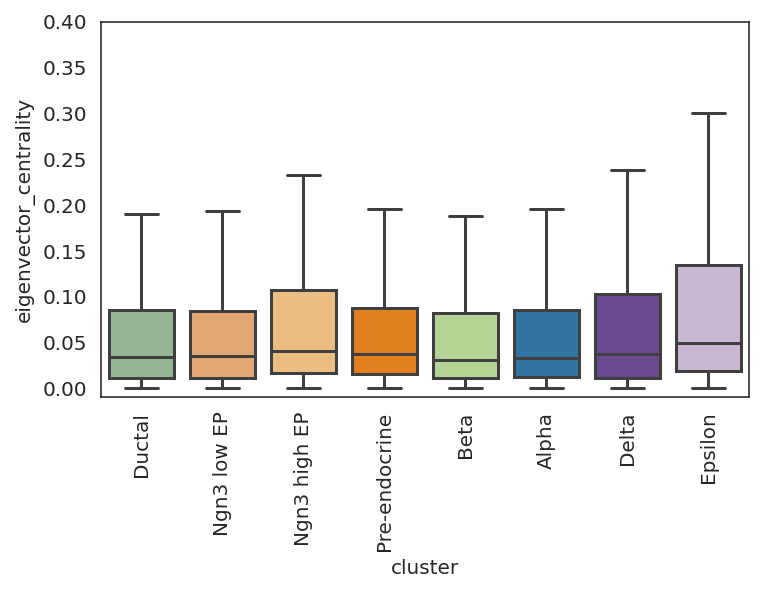

In [52]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([-0.01, 0.4])
links.plot_score_discributions(values=["eigenvector_centrality"], method="boxplot", save=f"{save_folder}")

## 8.2. Distribution of network entropy

/home/lorena/anaconda3/envs/celloracle_env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/lorena/anaconda3/envs/celloracle_env/lib/python3.6/site-packages/celloracle/network_analysis/links_object.py:344: RuntimeWarning: divide by zero encountered in log
  ent_norm.append(en/np.log(k[i]))
/home/lorena/anaconda3/envs/celloracle_env/lib/python3.6/site-packages/celloracle/network_analysis/links_object.py:344: RuntimeWarning: invalid value encountered in true_divide
  ent_norm.append(en/np.log(k[i]))
/home/lorena/anaconda3/envs/celloracle_env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/lorena/anaconda3/envs/celloracle_env/lib/python3.6/site-packages/celloracle/network_analysis/links_object.py:344: RuntimeWarning:

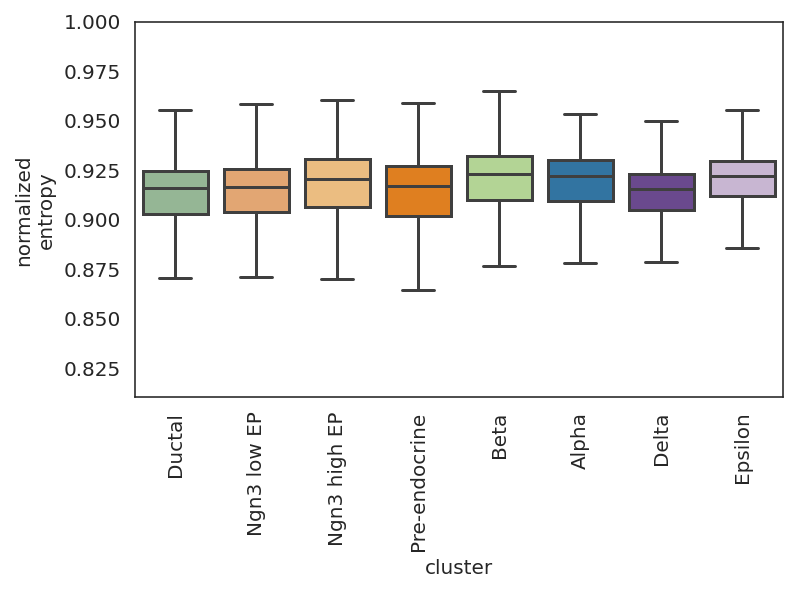

In [53]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0.9, 0.97])
links.plot_network_entropy_distributions(save=f"{save_folder}")

Using the network scores, we could pick up cluster-specific key TFs.
Gata2, Gata1, Klf1, E2f1, for example, are known to play an essential role in MEP, and these TFs showed high network score in our GRN.

However, it is important to note that network analysis alone cannot shed light on the specific functions or roles these TFs play in cell fate determination. 

In the next section, we will begin to investigate each TF’s contribution to cell fate by running GRN simulations